In [ ]:
import torch
from torchvision import transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor, TrainingArguments, Trainer
from datasets import load_dataset, load_metric

In [ ]:
from datasets import load_dataset

# Load dataset from Hugging Face
dataset = load_dataset("PranomVignesh/MRI-Images-of-Brain-Tumor")


Resolving data files:   0%|          | 0/3759 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1073 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/537 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3759 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1073 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/537 [00:00<?, ? examples/s]

In [ ]:
from torchvision import transforms
from transformers import ViTFeatureExtractor

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

In [ ]:
# Preprocess function
def preprocess_function(examples):
    images = [transform(image.convert("RGB")) for image in examples['image']]
    return {'pixel_values': images, 'labels': examples['label']}


In [ ]:
# Apply transformations
train_dataset = dataset['train'].map(preprocess_function, batched=True)
val_dataset = dataset['validation'].map(preprocess_function, batched=True)
test_dataset = dataset['test'].map(preprocess_function, batched=True)

In [ ]:
from transformers import ViTForImageClassification, TrainingArguments, Trainer
from datasets import load_metric

# Load pre-trained Vision Transformer model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=4)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define accuracy metric
accuracy = load_metric("accuracy")

<ipython-input-9-c3f755b349a0>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy = load_metric("accuracy")


In [ ]:
# Function to compute metrics
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return accuracy.compute(predictions=preds, references=p.label_ids)

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    remove_unused_columns=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Custom Dataset class for Hugging Face Trainer
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {'pixel_values': item['pixel_values'], 'labels': item['labels']}


In [ ]:
# Wrap datasets
train_dataset_hf = CustomDataset(train_dataset)
val_dataset_hf = CustomDataset(val_dataset)

In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_hf,
    eval_dataset=val_dataset_hf,
    compute_metrics=compute_metrics
)


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.072707,0.988816
2,No log,0.035009,0.997204
3,0.147300,0.030257,0.997204


TrainOutput(global_step=705, training_loss=0.11160811836837876, metrics={'train_runtime': 1404.2684, 'train_samples_per_second': 8.031, 'train_steps_per_second': 0.502, 'total_flos': 8.738928314530284e+17, 'train_loss': 0.11160811836837876, 'epoch': 3.0})

In [ ]:
# Wrap test dataset
test_dataset_hf = CustomDataset(test_dataset)

In [ ]:
# Evaluate the model
results = trainer.evaluate(test_dataset_hf)
print(results)

{'eval_loss': 0.04971668869256973, 'eval_accuracy': 0.9906890130353817, 'eval_runtime': 50.6687, 'eval_samples_per_second': 10.598, 'eval_steps_per_second': 0.671, 'epoch': 3.0}


In [ ]:
model.save_pretrained('./trained_vit_model')
feature_extractor.save_pretrained('./trained_vit_model')

['./trained_vit_model/preprocessor_config.json']

In [ ]:
from google.colab import files

In [ ]:
# Zip the model directory
!zip -r trained_vit_model.zip ./trained_vit_model

  adding: trained_vit_model/ (stored 0%)
  adding: trained_vit_model/model.safetensors (deflated 7%)
  adding: trained_vit_model/preprocessor_config.json (deflated 58%)
  adding: trained_vit_model/config.json (deflated 50%)


In [ ]:
# Download the zipped model
files.download('trained_vit_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_dataset = dataset['test']

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

In [ ]:
# Preprocess function
def preprocess_function(examples):
    images = [transform(image.convert("RGB")) for image in examples['image']]
    return {'pixel_values': images, 'labels': examples['label']}


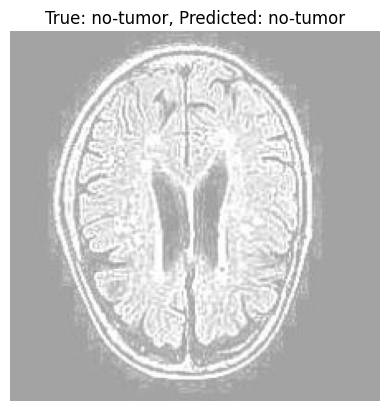

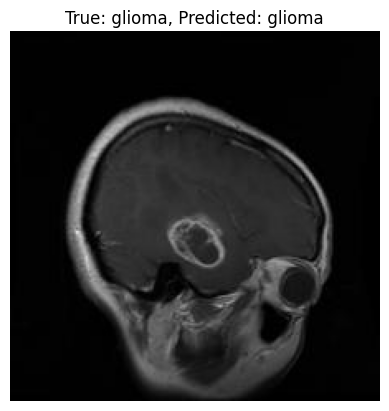

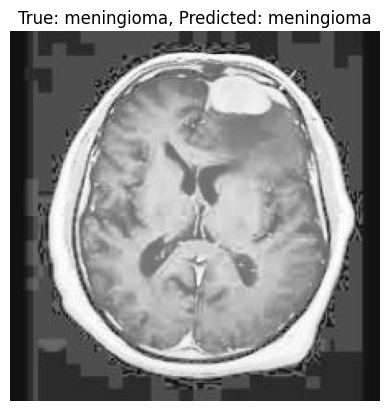

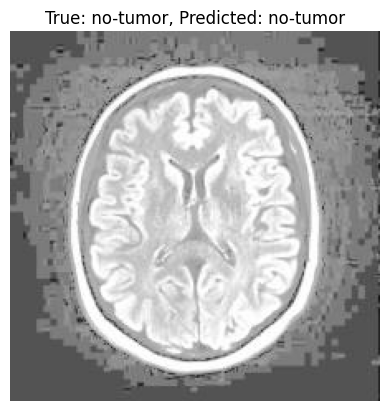

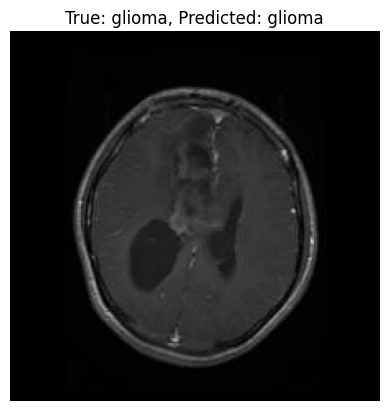

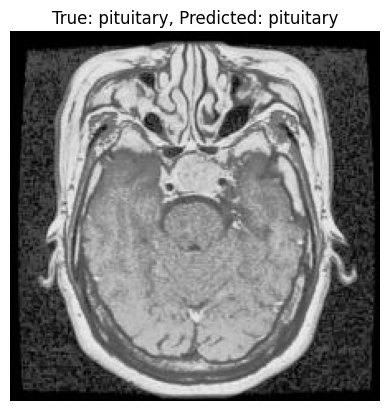

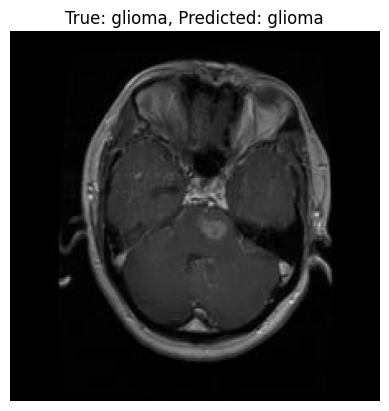

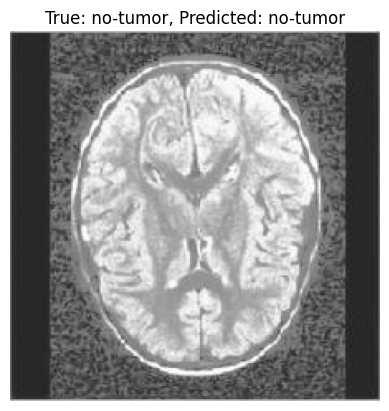

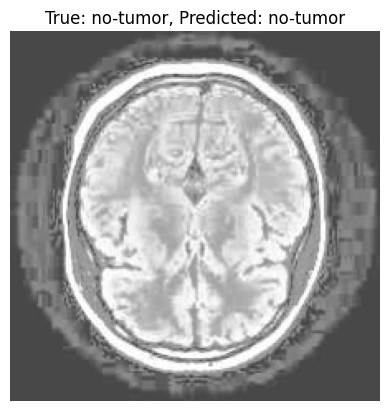

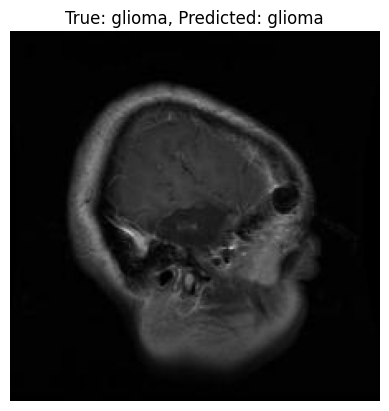

In [ ]:
# Load the pre-trained model and feature extractor
model = ViTForImageClassification.from_pretrained('./trained_vit_model')
feature_extractor = ViTImageProcessor.from_pretrained('./trained_vit_model')
labels = ['glioma', 'meningioma', 'no-tumor', 'pituitary']
# Define a function to visualize the predictions
# Define a function to visualize the predictions
import random

# Shuffle the indices
indices = list(range(len(test_dataset)))
random.shuffle(indices)

def visualize_predictions(images, labels, predictions, labels_list, num_samples=10):
    for i in range(num_samples):
        image = images[i]
        label = labels[i]
        prediction = predictions[i]
        plt.imshow(image)
        plt.title(f"True: {labels_list[label]}, Predicted: {labels_list[prediction]}")
        plt.axis('off')
        plt.show()
# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Predict the classification on the test dataset
predictions = []
with torch.no_grad():
    for sample in test_dataset:
        inputs = feature_extractor(images=sample['image'], return_tensors="pt").to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).tolist()
        predictions.extend(predicted_class_idx)


# Visualize the predictions

visualize_predictions([test_dataset['image'][i] for i in indices],
                       [test_dataset['label'][i] for i in indices],
                       [predictions[i] for i in indices],
                       labels,
                       num_samples=10)


In [ ]:
# Set your OpenAI API key
import openai
openai.api_key = ''

In [ ]:
import torch
from transformers import ViTForImageClassification, ViTImageProcessor
from torchvision import transforms
from PIL import Image
import gradio as gr
import openai
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import os
from openai import OpenAI

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model and image processor from the saved directory
model = ViTForImageClassification.from_pretrained('./trained_vit_model').to(device)
image_processor = ViTImageProcessor.from_pretrained('./trained_vit_model')

# Define class labels
labels = ['glioma', 'meningioma', 'no-tumor', 'pituitary']

def generate_gpt4_explanation(predicted_label, description):
    tumor_info = {
        "glioma": "Gliomas are typically irregular in shape and can infiltrate surrounding brain tissues. They often appear as heterogeneous masses with varying densities.",
        "meningioma": "Meningiomas usually have a well-defined, homogeneous appearance and may cause changes in adjacent bone structures. They are generally located near the meninges.",
        "pituitary tumor": "Pituitary tumors are found in the sellar region and often show characteristic enhancement patterns on contrast imaging. They may cause changes in the surrounding structures due to their location.",
        "no-tumor": "In the case of no tumor, the brain scan would not show any abnormal growths or lesions, but may display normal anatomical variations."
    }

    prompt = f"""
    Consider the following medical information about {predicted_label}s:
    {tumor_info[predicted_label]}

    The model predicted the label: {predicted_label}. The Grad-CAM highlights the regions of the image that contributed to the model's prediction: {description}.

    Provide a detailed explanation of why the model might have predicted {predicted_label}:
    - **Texture and Density**
    - **Shape and Boundaries**
    - **Location**
    """
    client = OpenAI(api_key='')
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant with expertise in medical imaging and machine learning."},
            {"role": "user", "content": prompt},
        ],
        max_tokens=300
    )
    explanation = response.choices[0].message.content
    return f"The predicted label is {predicted_label}. {explanation}"

class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]
    activations = activations.view(activations.shape[0], 14, 14, activations.shape[2])
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

def interpret_image(image):
    try:
        # Define transformations
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to 224x224 as expected by the model
            transforms.ToTensor(),
            transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
        ])

        # Preprocess the image
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Generate prediction
        model.eval()
        with torch.no_grad():
            outputs = model(image_tensor)
            logits = outputs.logits
            predicted_class_idx = logits.argmax(-1).item()
            predicted_label = labels[predicted_class_idx]

        # Generate GradCAM
        target_layer = model.vit.encoder.layer[-2].output
        targets_for_gradcam = [ClassifierOutputTarget(predicted_class_idx)]

        with GradCAM(model=HuggingfaceToTensorModelWrapper(model),
                     target_layers=[target_layer],
                     reshape_transform=reshape_transform_vit_huggingface) as cam:
            grayscale_cam = cam(input_tensor=image_tensor, targets=targets_for_gradcam)[0]

        # Overlay GradCAM on the input image
        image_np = np.array(image.resize((224, 224))) / 255.0  # Normalize to [0, 1] range
        grayscale_cam = cv2.resize(grayscale_cam, (image_np.shape[1], image_np.shape[0]))
        overlay = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

        # Generate GPT-4 explanation
        true_label = "Unknown"  # As we don't have the true label here, set it as unknown
        description = "Highlighted regions indicate areas of importance for the model's prediction."
        explanation = generate_gpt4_explanation(true_label, predicted_label, description)

        return overlay, explanation
    except Exception as e:
        print(f"Error: {e}")
        return None, str(e)

# Define Gradio interface
interface = gr.Interface(
    fn=interpret_image,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Image(type="numpy"), gr.Textbox()],
    title="Image Classification Interpretability with GradCAM and GPT",
    description="Upload an image to see the GradCAM overlay."
)




In [ ]:
# Launch the app
interface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://55c2a4a8f479666a16.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
